In [16]:
from multi_imbalance.datasets import load_datasets
import experiment as ex
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from multi_imbalance.utils.metrics import gmean_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from utils import plot_embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch
from utils import calc_embeddings

In [17]:
datasets = load_datasets()

In [18]:
ds_name = 'cmc'
test_on_all_folds = True
test_all_ds = False

In [19]:
datasets = ex.one_hot_encode_all(datasets)

In [20]:
config = ex.config_calculation_strategy3(datasets)

In [21]:
np.unique(datasets["new_yeast"]['target'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [22]:
config['cmc'] = {'nn_config': {'units_1st_layer': 17,
  'units_2nd_layer': 256,
  'units_3rd_layer': 128,
  'units_latent_layer': 16},
 'weighted_triplet_loss': True,
 'lr': 0.0005,
 'batch_size': 16,
 'gamma': 0.99,
 'epochs': 100}

config['dermatology'] = {'nn_config': {'units_1st_layer': 97,
   'units_2nd_layer': 512,
   'units_3rd_layer': 256,
   'units_latent_layer': 16},
  'weighted_triplet_loss': True,
  'lr': 0.0015,
  'batch_size': 16,
  'gamma': 0.95,
  'epochs': 50}

config['hayes-roth'] = {'nn_config': {'units_1st_layer': 11,
  'units_2nd_layer': 128,
  'units_3rd_layer': 64,
  'units_latent_layer': 12},
 'weighted_triplet_loss': True,
 'lr': 0.005,
 'batch_size': 16,
 'gamma': 0.95,
 'epochs': 100}

config['new_vehicle'] = {'nn_config': {'units_1st_layer': 18,
  'units_2nd_layer': 256,
  'units_3rd_layer': 128,
  'units_latent_layer': 16},
 'weighted_triplet_loss': True,
 'lr': 0.003,
 'batch_size': 16,
 'gamma': 0.99,
 'epochs': 100}

config['new_yeast'] = {'nn_config': {'units_1st_layer': 9,
  'units_2nd_layer': 300,
  'units_3rd_layer': 200,
  'units_latent_layer': 6},
 'weighted_triplet_loss': True,
 'lr': 0.003,
 'batch_size': 16,
 'gamma': 0.95,
 'epochs': 100}

config['balance-scale'] = {'nn_config': {'units_1st_layer': 16,
  'units_2nd_layer': 256,
  'units_3rd_layer': 128,
  'units_latent_layer': 3},
 'weighted_triplet_loss': True,
 'lr': 0.0004,
 'batch_size': 16,
 'gamma': 0.99,
 'epochs': 100}

config['cleveland'] = {'nn_config': {'units_1st_layer': 24,
  'units_2nd_layer': 72,
  'units_3rd_layer': 48,
  'units_latent_layer': 16},
 'weighted_triplet_loss': True,
 'lr': 0.004,
 'batch_size': 16,
 'gamma': 0.99,
 'epochs': 100}

config['cleveland_v2'] = {'nn_config': {'units_1st_layer': 23,
  'units_2nd_layer': 256,
  'units_3rd_layer': 128,
  'units_latent_layer': 8},
 'weighted_triplet_loss': True,
 'lr': 0.004,
 'batch_size': 16,
 'gamma': 0.99,
 'epochs': 100}

config['glass'] = {'nn_config': {'units_1st_layer': 9,
  'units_2nd_layer': 256,
  'units_3rd_layer': 128,
  'units_latent_layer': 16},
 'weighted_triplet_loss': True,
 'lr': 0.003,
 'batch_size': 16,
 'gamma': 0.99,
 'epochs': 100}

config['thyroid-newthyroid'] = {'nn_config': {'units_1st_layer': 5,
  'units_2nd_layer': 64,
  'units_3rd_layer': 32,
  'units_latent_layer': 8},
 'weighted_triplet_loss': True,
 'lr': 0.003,
 'batch_size': 16,
 'gamma': 0.95,
 'epochs': 100}

config['new_ecoli'] = {'nn_config': {'units_1st_layer': 7,
  'units_2nd_layer': 128,
  'units_3rd_layer': 64,
  'units_latent_layer': 8},
 'weighted_triplet_loss': True,
 'lr': 0.005,
 'batch_size': 16,
 'gamma': 0.85,
 'epochs': 100}

config['new_led7digit'] = {'nn_config': {'units_1st_layer': 7,
  'units_2nd_layer': 64,
  'units_3rd_layer': 32,
  'units_latent_layer': 8},
 'weighted_triplet_loss': True,
 'lr': 0.003,
 'batch_size': 16,
 'gamma': 0.95,
 'epochs': 70}

config['new_winequality-red'] = {'nn_config': {'units_1st_layer': 11,
  'units_2nd_layer': 128,
  'units_3rd_layer': 64,
  'units_latent_layer': 12},
 'weighted_triplet_loss': True,
 'lr': 0.003,
 'batch_size': 16,
 'gamma': 0.95,
 'epochs': 100}

config['4delikatne-bezover-cut'] = {'nn_config': {'units_1st_layer': 2,
   'units_2nd_layer': 64,
   'units_3rd_layer': 32,
   'units_latent_layer': 4},
  'weighted_triplet_loss': True,
  'lr': 0.003,
  'batch_size': 16,
  'gamma': 0.99,
  'epochs': 100}

In [23]:
from experiment import dt_name_to_cols_to_encode

In [24]:
for dataset_name in dt_name_to_cols_to_encode:
    data, target = datasets[dataset_name]['data'], datasets[dataset_name]['target']
    config[f"{dataset_name}"]['nn_config']['units_decision_layer'] = np.unique(target).size
    config[f"{dataset_name}_encoded"]['nn_config']['units_decision_layer'] = np.unique(target).size

In [25]:
config

{'1czysty-cut': {'nn_config': {'units_1st_layer': 2,
   'units_2nd_layer': 16,
   'units_3rd_layer': 8,
   'units_latent_layer': 4,
   'units_decision_layer': 3},
  'weighted_triplet_loss': True,
  'lr': 0.003,
  'batch_size': 16,
  'gamma': 0.99,
  'epochs': 100},
 '2delikatne-cut': {'nn_config': {'units_1st_layer': 2,
   'units_2nd_layer': 16,
   'units_3rd_layer': 8,
   'units_latent_layer': 4,
   'units_decision_layer': 3},
  'weighted_triplet_loss': True,
  'lr': 0.003,
  'batch_size': 16,
  'gamma': 0.99,
  'epochs': 100},
 '3mocniej-cut': {'nn_config': {'units_1st_layer': 2,
   'units_2nd_layer': 16,
   'units_3rd_layer': 8,
   'units_latent_layer': 4,
   'units_decision_layer': 3},
  'weighted_triplet_loss': True,
  'lr': 0.003,
  'batch_size': 16,
  'gamma': 0.99,
  'epochs': 100},
 '4delikatne-bezover-cut': {'nn_config': {'units_1st_layer': 2,
   'units_2nd_layer': 64,
   'units_3rd_layer': 32,
   'units_latent_layer': 4,
   'units_decision_layer': 3},
  'weighted_triplet_los

cmc


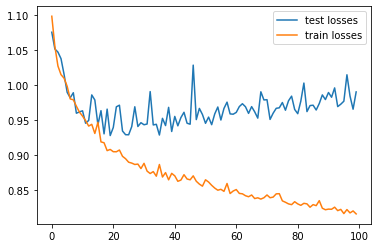

100%|██████████| 1178/1178 [00:00<00:00, 3145.11it/s]


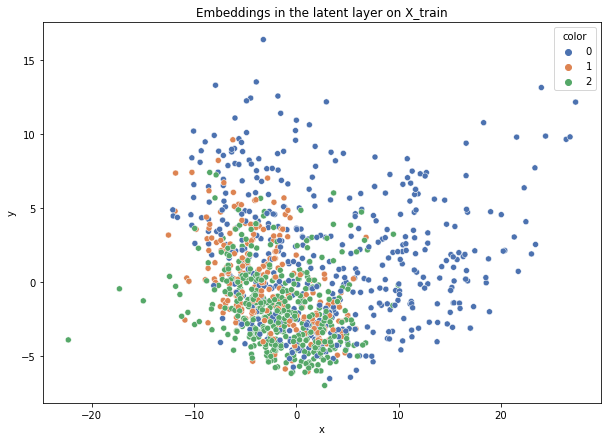

Softmax-f1: 0.501
Softmax-gmean: 0.507


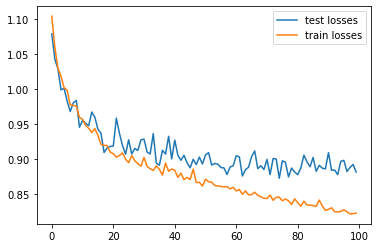

100%|██████████| 1178/1178 [00:00<00:00, 3101.29it/s]


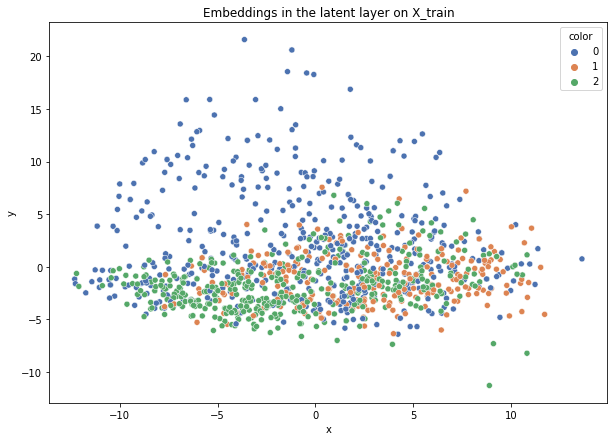

Softmax-f1: 0.577
Softmax-gmean: 0.586


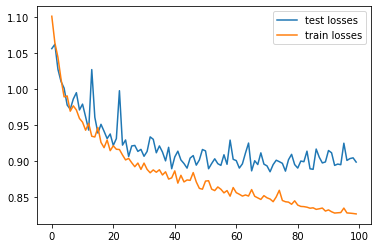

100%|██████████| 1178/1178 [00:00<00:00, 3379.72it/s]


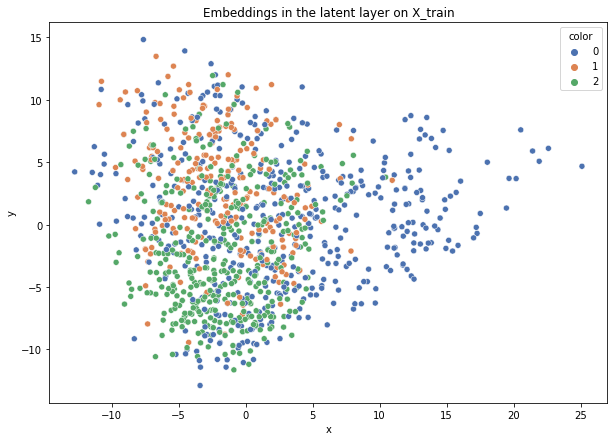

Softmax-f1: 0.528
Softmax-gmean: 0.514


In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

result_dict = defaultdict(list)

if test_all_ds:
    ds_names = dt_name_to_cols_to_encode.keys()
else:
    ds_names = [ds_name]
for dataset_name in ds_names:
    print(dataset_name)
    result_dict["dataset"].append(dataset_name)
    fold_result_dict = defaultdict(list)

    X, y = datasets[dataset_name]['data'], datasets[dataset_name]['target']
    X_encoded, y = datasets[f"{dataset_name}_encoded"]['data'], datasets[f"{dataset_name}_encoded"]['target']
    
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    n_splits = skf.get_n_splits(X, y)
    
    folds = []
    if test_on_all_folds:
        folds = skf.split(X, y)
    else:
        folds = list(skf.split(X, y))[1:2]
        
    for train_index, test_index in folds:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        X_train_enc, X_test_enc = X_encoded[train_index], X_encoded[test_index]
        
        cfg = config[dataset_name]
        
        model = ex.train_classification(X_train_enc, y_train, X_test_enc, y_test, cfg)
        
        # Visualize embeddings
        dataset1 = TensorDataset(torch.Tensor(X_train_enc), torch.Tensor(y_train))
        test_loader1 = torch.utils.data.DataLoader(dataset1, batch_size=1)
        
        embeddings, labels = calc_embeddings(model, device, test_loader1)
        pca = PCA(n_components=2)
        plot_embeddings(pca.fit_transform(embeddings), y_train)
        plt.title("Embeddings in the latent layer on X_train")
        plt.show() 
        
        dataset2 = TensorDataset(torch.Tensor(X_test_enc), torch.Tensor(y_test))
        test_loader2 = torch.utils.data.DataLoader(dataset2, batch_size=1)
        
        preds = []
        model.eval()
        with torch.no_grad():
            for data, target in test_loader2:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                preds.append(pred.item())
#                 print(f"Pred: {pred.item()}, target: {target.item()}, output: {output}")

        clf_name = "Softmax"
        gmean = gmean_score(y_test, preds)
        f1 = f1_score(y_test, preds, average='macro')
        fold_result_dict[f"{clf_name}-f1"].append(f1)
        fold_result_dict[f"{clf_name}-gmean"].append(gmean)
            
        
        for key in sorted(list(fold_result_dict.keys())):
            print(f"{key}: {np.round(fold_result_dict[key][-1],3)}")
            
    for k in fold_result_dict:
        result_dict[k].append(np.mean(fold_result_dict[k]))

In [ ]:
results_df = pd.DataFrame.from_dict(result_dict)

In [ ]:
results_df

In [ ]:
results_df.filter(regex=("dataset|Softmax-f1*")).style.highlight_max(color = 'lightgreen', axis = 1)

In [ ]:
results_df.filter(regex=("dataset|Softmax-gmean*")).style.highlight_max(color = 'lightgreen', axis = 1)